In [ ]:
from keras.applications.densenet import DenseNet121
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#call pretrained resnet model
conv_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(256,256, 3))

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
#inactivate some layers
for layer in conv_base.layers[:149]:
    layer.trainable = False
for layer in conv_base.layers[149:]:
    layer.trainable = True
    
conv_base.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
#load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#normalize data
x_train = x_train / 255.0
x_test = x_test / 255.0

#turn class_names into numpy array with 0 and 1
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

print(x_train.shape)
print(x_test.shape)

170508288/170498071 [==============================] - 3s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

#augment data
datagen = ImageDataGenerator(
    zoom_range= (0.5,1.5),
    width_shift_range=(-5,5),
    height_shift_range=(-5,5),
    horizontal_flip=True,
    validation_split=0.2)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train)

In [ ]:
train_datagen = datagen.flow(x_train, y_train, batch_size=32,subset='training')
test_datagen = datagen.flow(x_train, y_train, batch_size=8, subset='validation')

In [ ]:
#build model
model = models.Sequential()
model.add(layers.Lambda(lambda x:keras.backend.resize_images(x, height_factor=8,width_factor=8,data_format='channels_last')))
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

#compile model with RMSprop optimizers
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.01), loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
#load the saved model to conitnue training
model = models.load_model("/content/drive/MyDrive/Fund_of_AI_models/densenet121_cifar10.h5")

In [ ]:
from keras.callbacks import ModelCheckpoint

# define the checkpoint
filepath = "/content/drive/MyDrive/Fund_of_AI_models/densenet121_cifar10.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_freq = 'epoch')
callbacks_list = [checkpoint]

In [ ]:
#fit the model
history = model.fit(train_datagen, epochs=10, batch_size=20,  validation_data=test_datagen, callbacks=callbacks_list)

Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 0.3801 - accuracy: 0.8846
Epoch 1: val_accuracy improved from 0.87880 to 0.88230, saving model to /content/drive/MyDrive/Fund_of_AI_models/densenet121_cifar10.h5
1250/1250 [==============================] - 186s 144ms/step - loss: 0.3801 - accuracy: 0.8846 - val_loss: 0.3753 - val_accuracy: 0.8823
Epoch 2/10
1250/1250 [==============================] - ETA: 0s - loss: 0.3661 - accuracy: 0.8911
Epoch 2: val_accuracy did not improve from 0.88230
1250/1250 [==============================] - 178s 142ms/step - loss: 0.3661 - accuracy: 0.8911 - val_loss: 0.4339 - val_accuracy: 0.8678
Epoch 3/10
1250/1250 [==============================] - ETA: 0s - loss: 0.3769 - accuracy: 0.8878
Epoch 3: val_accuracy did not improve from 0.88230
1250/1250 [==============================] - 178s 142ms/step - loss: 0.3769 - accuracy: 0.8878 - val_loss: 0.5520 - val_accuracy: 0.8276
Epoch 4/10
1250/1250 [==============================] - E

KeyboardInterrupt: ignored

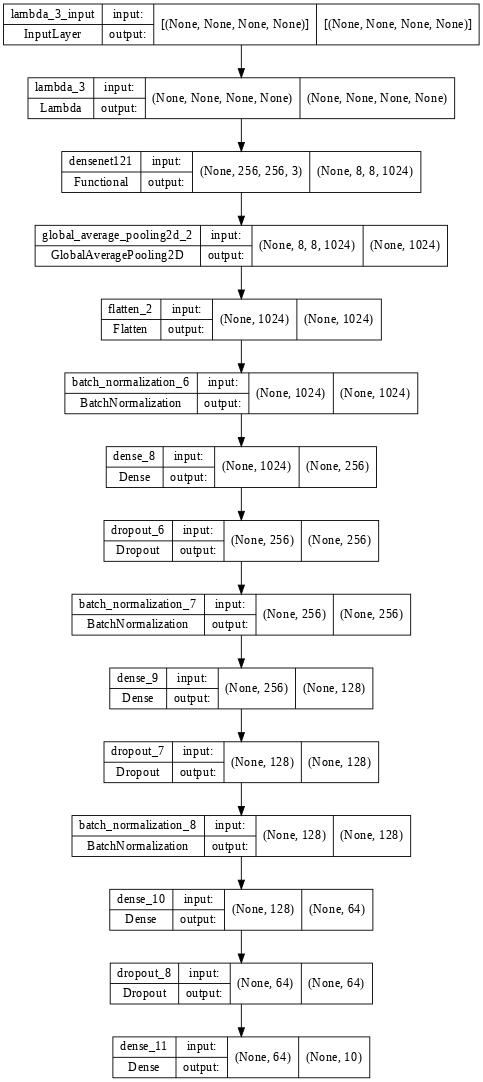

In [ ]:
#model architectures
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
model = models.load_model("/content/drive/MyDrive/Fund_of_AI_models/densenet121_cifar10.h5")

In [ ]:
#evaluate model on untoched raw test images
model.evaluate(x_test, y_test)

313/313 [==============================] - 23s 65ms/step - loss: 0.2653 - accuracy: 0.9231


[0.2653351426124573, 0.9230999946594238]

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (None, None, None, None)  0         
                                                                 
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
 batch_normalization_6 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 256)              

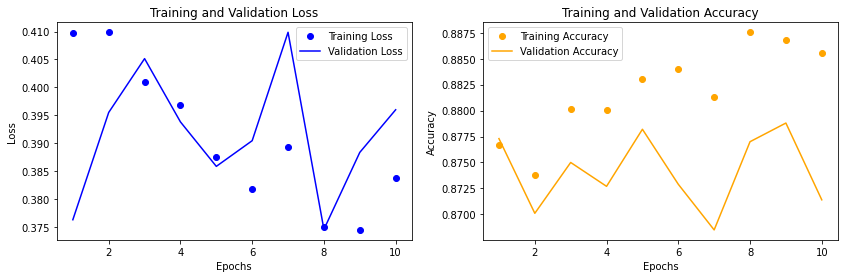

In [ ]:
#draw train/test accuracy and loss graphs
istory_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training Accuracy', c='orange')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy', c='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
# model = models.load_model("/content/drive/MyDrive/Fund_of_AI_models/densenet121_cifar10")

In [ ]:
#report on untouched raw test set
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
predict_x=model.predict(x_test)
# print(predict_x)
predictions=np.argmax(predict_x, axis = 1)
# print(predictions)
print(classification_report(np.argmax(y_test, axis=1),predictions))
print(confusion_matrix(np.argmax(y_test, axis=1),predictions))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1000
           1       0.96      0.98      0.97      1000
           2       0.89      0.86      0.88      1000
           3       0.89      0.80      0.84      1000
           4       0.87      0.95      0.91      1000
           5       0.93      0.85      0.89      1000
           6       0.89      0.97      0.93      1000
           7       0.98      0.94      0.96      1000
           8       0.94      0.97      0.96      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

[[949   1   4   3   4   0   2   2  25  10]
 [  1 976   0   0   0   0   3   0   5  15]
 [ 47   0 864   4  33   7  36   0   7   2]
 [ 11   1  49 799  38  44  39   3   9   7]
 [  2   1   9  10 951   2  14   9   1   1]
 [  3   1  20  68  32 849 

In [ ]:
#report on transformed test set
val_datagen = datagen.flow(x_test, y_test, batch_size=8)
model.evaluate(val_datagen)

1250/1250 [==============================] - 39s 30ms/step - loss: 0.3814 - accuracy: 0.8816


[0.38137194514274597, 0.881600022315979]